In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# CoinGecko API base URL
base_url = "https://api.coingecko.com/api/v3"

# Function to fetch historical Bitcoin data
def get_bitcoin_data(days):
    # Calculate the timestamp for 'days' ago
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    
    # API endpoint for market chart data
    endpoint = f"/coins/bitcoin/market_chart"
    params = {
        "vs_currency": "usd",  # Prices in USD
        "days": days,          # How many days of data
        "interval": "daily"    # Daily data points
    }
    
    # Make the API request
    response = requests.get(base_url + endpoint, params=params)
    data = response.json()
    
    # Extract prices and timestamps
    prices = data["prices"]  # List of [timestamp, price]
    
    # Convert to a DataFrame
    df = pd.DataFrame(prices, columns=["timestamp", "price"])
    df["date"] = pd.to_datetime(df["timestamp"], unit="ms")  # Convert timestamp to readable date
    df["price"] = df["price"].astype(float)  # Ensure price is float
    df = df[["date", "price"]]  # Keep only date and price
    
    return df

# Fetch 365 days of data as a starting point
btc_data = get_bitcoin_data(365)

# Peek at the data
print(btc_data.head())
print(btc_data.tail())

        date         price
0 2024-03-04  63053.105439
1 2024-03-05  68186.645934
2 2024-03-06  64291.536558
3 2024-03-07  66145.919279
4 2024-03-08  66944.876391
                   date         price
361 2025-02-28 00:00:00  84709.144778
362 2025-03-01 00:00:00  84441.901224
363 2025-03-02 00:00:00  86005.256297
364 2025-03-03 00:00:00  94261.532865
365 2025-03-03 04:20:42  92710.123632


In [2]:
# Assuming btc_data is your DataFrame from before
def prepare_data(df, lookback=7):
    # Create features: prices from the past 'lookback' days
    for i in range(1, lookback + 1):
        df[f"price_lag_{i}"] = df["price"].shift(i)
    
    # Target: next day's price
    df["next_price"] = df["price"].shift(-1)
    
    # Drop rows with NaN (from shifting)
    df = df.dropna()
    
    return df

# Prepare data with a 7-day lookback
btc_prepared = prepare_data(btc_data, lookback=7)

# Check the result
print(btc_prepared.head())

         date         price   price_lag_1   price_lag_2   price_lag_3  \
7  2024-03-11  69075.666882  68508.003963  68315.251921  66944.876391   
8  2024-03-12  72130.553008  69075.666882  68508.003963  68315.251921   
9  2024-03-13  71467.173503  72130.553008  69075.666882  68508.003963   
10 2024-03-14  73097.767027  71467.173503  72130.553008  69075.666882   
11 2024-03-15  71420.031801  73097.767027  71467.173503  72130.553008   

     price_lag_4   price_lag_5   price_lag_6   price_lag_7    next_price  
7   66145.919279  64291.536558  68186.645934  63053.105439  72130.553008  
8   66944.876391  66145.919279  64291.536558  68186.645934  71467.173503  
9   68315.251921  66944.876391  66145.919279  64291.536558  73097.767027  
10  68508.003963  68315.251921  66944.876391  66145.919279  71420.031801  
11  69075.666882  68508.003963  68315.251921  66944.876391  69497.763193  


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Split features (X) and target (y)
X = btc_prepared[[f"price_lag_{i}" for i in range(1, 8)]]  # Lag features
y = btc_prepared["next_price"]  # Target

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluate with RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.2f}")

# Predict the next day's price using the most recent data
latest_data = btc_prepared.tail(1)[[f"price_lag_{i}" for i in range(1, 8)]]
next_day_pred = rf_model.predict(latest_data)[0]
latest_date = btc_prepared["date"].iloc[-1]
print(f"Predicted price for {latest_date + timedelta(days=1):%Y-%m-%d}: ${next_day_pred:.2f}")

Root Mean Squared Error: 2838.73
Predicted price for 2025-03-04: $91787.95


In [8]:
print(btc_prepared[["date", "price"]].tail())

          date         price
360 2025-02-27  83900.114965
361 2025-02-28  84709.144778
362 2025-03-01  84441.901224
363 2025-03-02  86005.256297
364 2025-03-03  94261.532865


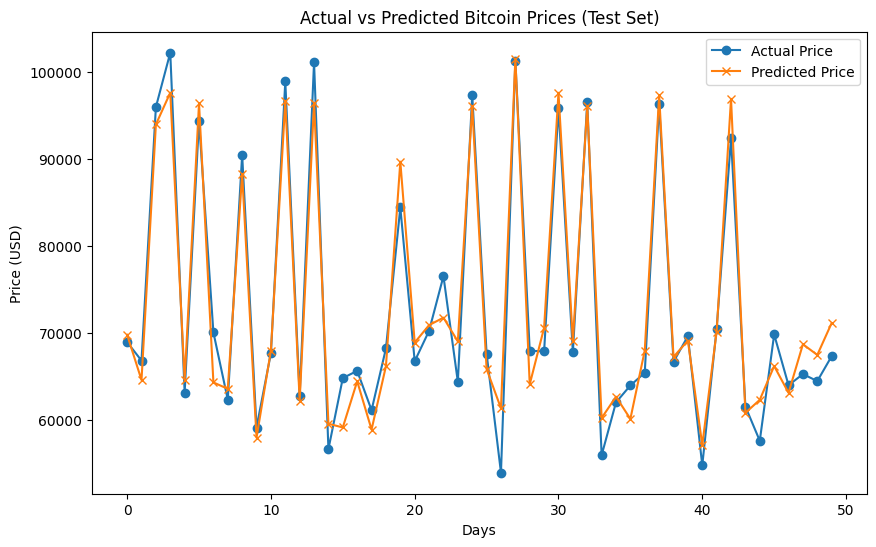

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for test set (first 50 points)
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:50], label="Actual Price", marker="o")
plt.plot(y_pred[:50], label="Predicted Price", marker="x")
plt.title("Actual vs Predicted Bitcoin Prices (Test Set)")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Save the plot for your portfolio
plt.savefig("btc_prediction_plot.png")

## Plot Analysis

- **Actual vs Predicted**: The blue dots (Actual Price) and orange Xs (Predicted Price) show 50 days from our test set. The actual prices bounce between ~$60,000 and ~$100,000, which matches our recent data (e.g., $94,261 on March 3). The predictions follow a similar trend but lag a bit—notice how the Xs don’t always hit the peaks or troughs exactly. That’s your RMSE ($2,838) showing up visually.

- **Volatility**: The sharp ups and downs (especially those $10K+ swings) scream crypto chaos. Our Random Forest is doing its best with just lagged prices, but it’s struggling to nail the extremes.

- **Fit**: It’s not perfect—some predictions overshoot or undershoot—but for a first pass with basic features, it’s a solid effort. The general shape is there, which is promising.

## What This Means

- **Strength**: We’ve got a working pipeline—data fetch, feature prep, model training, and visualization. That’s a killer combo.

- **Room to Grow**: The lag between actual and predicted prices suggests the model could use more juice—more features (like volume or moving averages) or a longer lookback might help. The RMSE backs this up: $2,838 is decent but could be tighter for bragging rights.

Root Mean Squared Error: 2659.40
Predicted price for 2025-03-04: $91160.99


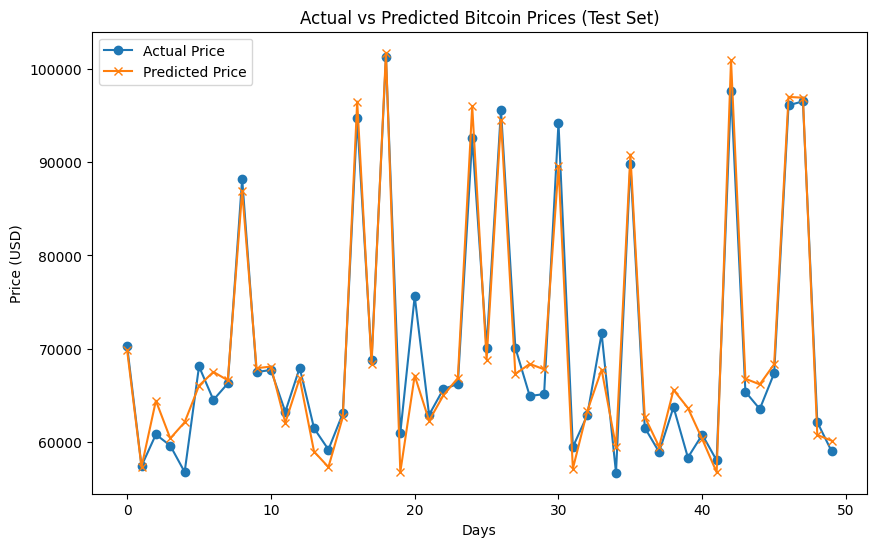

Prediction and RMSE saved to 'prediction.txt'


In [15]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Function to fetch historical Bitcoin data (unchanged)
def get_bitcoin_data(days):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    base_url = "https://api.coingecko.com/api/v3"
    endpoint = f"/coins/bitcoin/market_chart"
    params = {
        "vs_currency": "usd",
        "days": days,
        "interval": "daily"
    }
    response = requests.get(base_url + endpoint, params=params)
    data = response.json()
    prices = data["prices"]
    df = pd.DataFrame(prices, columns=["timestamp", "price"])
    df["date"] = pd.to_datetime(df["timestamp"], unit="ms")
    df["price"] = df["price"].astype(float)
    df = df[["date", "price"]]
    return df

# Updated function to prepare data with moving average
def prepare_data(df, lookback=7):
    for i in range(1, lookback + 1):
        df[f"price_lag_{i}"] = df["price"].shift(i)
    df["moving_avg_14"] = df["price"].rolling(window=14).mean()  # Change to 14-day window
    df["next_price"] = df["price"].shift(-1)
    df = df.dropna()
    return df

# Fetch and prepare data
btc_data = get_bitcoin_data(365)
btc_prepared = prepare_data(btc_data, lookback=7)

# Split features and target
X = btc_prepared[[f"price_lag_{i}" for i in range(1, 8)] + ["moving_avg_14"]]  # Include moving_avg_7
y = btc_prepared["next_price"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model with tuned parameters
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluate with RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.2f}")

# Predict the next day's price
latest_data = btc_prepared.tail(1)[[f"price_lag_{i}" for i in range(1, 8)] + ["moving_avg_14"]]
next_day_pred = rf_model.predict(latest_data)[0]
latest_date = btc_prepared["date"].iloc[-1]
print(f"Predicted price for {latest_date + timedelta(days=1):%Y-%m-%d}: ${next_day_pred:.2f}")


# Plot actual vs predicted for test set
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:50], label="Actual Price", marker="o")
plt.plot(y_pred[:50], label="Predicted Price", marker="x")
plt.title("Actual vs Predicted Bitcoin Prices (Test Set)")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.savefig("btc_prediction_plot.png")
plt.show()

# Save prediction and RMSE to file
with open("prediction.txt", "w") as f:
    f.write(f"Predicted price for {latest_date + timedelta(days=1):%Y-%m-%d}: ${next_day_pred:.2f}\n")
    f.write(f"RMSE: {rmse:.2f}")
print("Prediction and RMSE saved to 'prediction.txt'")

1. **14-Day Moving Average**: The longer window likely smoothed out some of the daily noise better than the 7-day version, giving the Random Forest a clearer trend to work with alongside the lagged prices.

2. **Tuned Parameters**: The 200 trees and max_depth=10 kept the model from overfitting, letting the new feature shine.

3. **Data Fit**: With 365 days of data, the 14-day average probably hit a sweet spot for your dataset’s volatility.